In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

In [2]:
search_result = lk.search_lightcurve('TIC 445859771', author='SPOC')
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0
1,TESS Sector 22,2020,SPOC,120,445859771,0.0
2,TESS Sector 23,2020,SPOC,120,445859771,0.0
3,TESS Sector 48,2022,SPOC,120,445859771,0.0


In [3]:
search_result[0]

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,SPOC,120,445859771,0.0


In [4]:
#for column in search_result.table.columns:
#  print(column)

In [5]:
lc = search_result.download_all()
lc

LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 445859771" SECTOR=15 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 445859771" SECTOR=22 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 445859771" SECTOR=23 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 445859771" SECTOR=48 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [6]:
lc[0].columns

<TableColumns names=('time','flux','flux_err','timecorr','cadenceno','centroid_col','centroid_row','sap_flux','sap_flux_err','sap_bkg','sap_bkg_err','pdcsap_flux','pdcsap_flux_err','quality','psf_centr1','psf_centr1_err','psf_centr2','psf_centr2_err','mom_centr1','mom_centr1_err','mom_centr2','mom_centr2_err','pos_corr1','pos_corr2')>

In [7]:
type(lc[0].timecorr)

astropy.units.quantity.Quantity

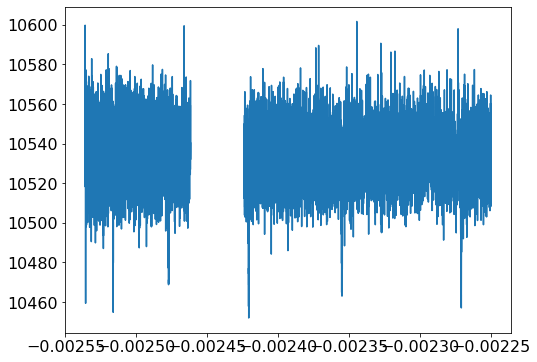

In [8]:
plt.plot(lc[0].timecorr, lc[0].flux)

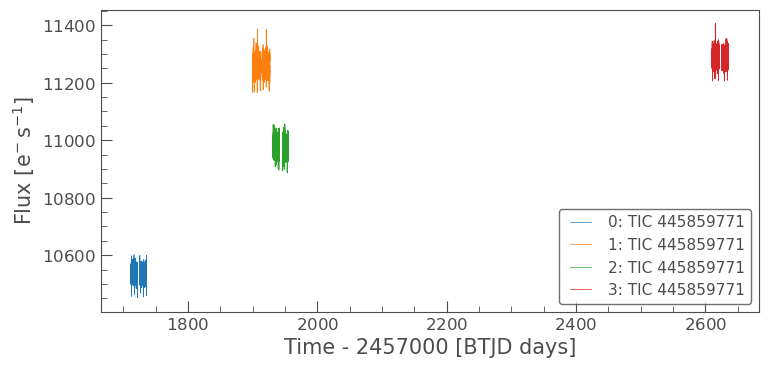

In [9]:
lc.plot();

In [10]:
lc_stitch = lc.stitch(lambda x: x.remove_nans())

In [11]:
lc_stitch.pdcsap_flux.value == lc_stitch.flux.value

array([ True,  True,  True, ...,  True,  True,  True])

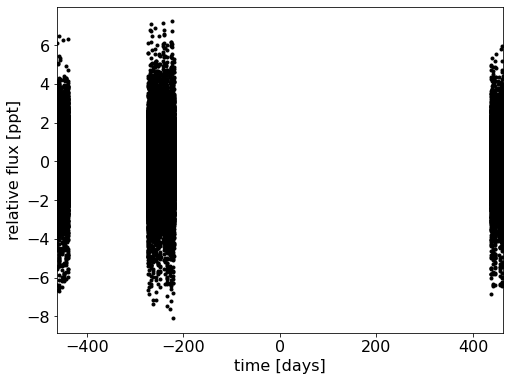

In [12]:
lc_normalized = lc.stitch(lambda x: x.remove_nans().remove_outliers().normalize())
time = lc_normalized.time.value
flux = lc_normalized.flux
ref_time = 0.5 * (np.min(time) + np.max(time))

x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

In [13]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

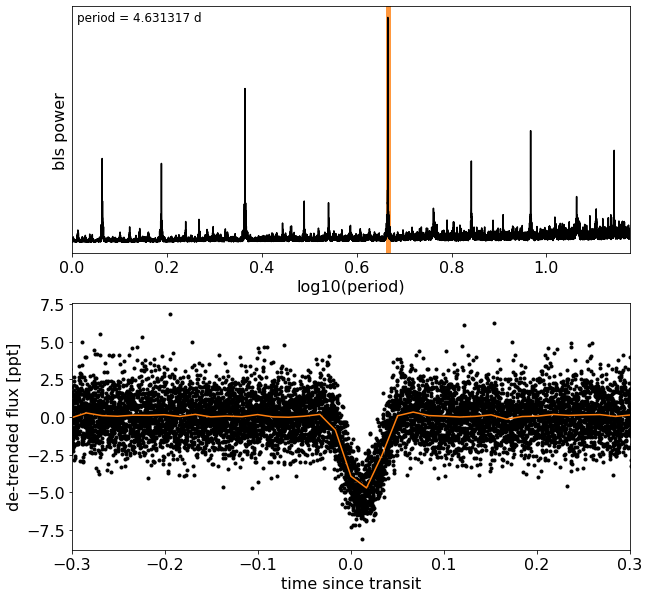

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.6f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [15]:
print(bls_period) 
print(bls_t0)
print(bls_depth)
print(ref_time+bls_t0)
print(ref_time)

4.631316790471438
-461.34256457198444
2.012215469970223
1712.3327627528251
2173.6753273248096


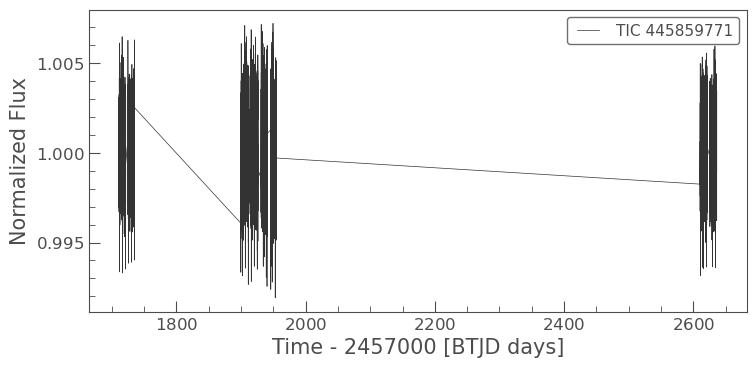

In [16]:
lc_normalized.plot();

In [17]:
lc_normalized_folded = lc_normalized.fold(period = bls_period, epoch_time = bls_t0+ref_time)

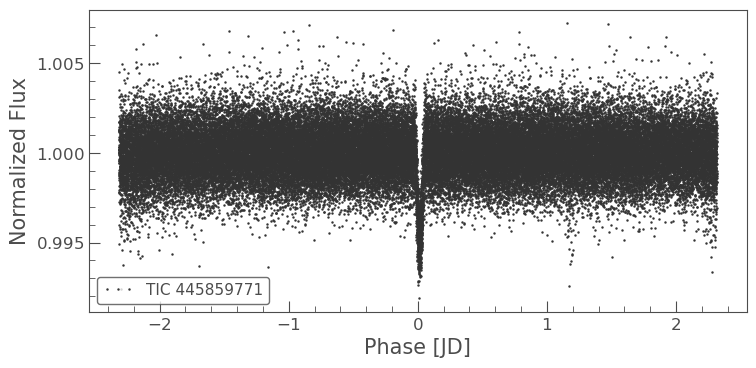

In [18]:
lc_normalized_folded.plot(marker='.', markersize=1.5,ls='');
#plt.savefig('toi_1273_tess_data_folded.png',dpi=400,bbox_inches='tight')
#plt.xlim(-0.2,0.2)

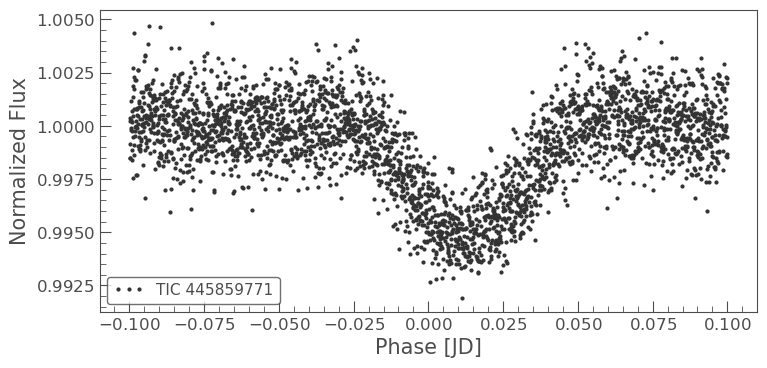

In [19]:
_ = lc_normalized_folded.truncate(before = -0.1, after= 0.1, column = 'time').plot(marker='o', ls='')
#plt.savefig('toi_1273_folded_trunc.png',dpi=400,bbox_inches='tight')

In [20]:
lc2 = lc_normalized_folded.truncate(before = -0.1, after= 0.1, column = 'time')

In [21]:
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

In [22]:
#bls_period = 4.63133263
#bls_t0 = 2458712.34791
#bls_depth = 0.00414383

phase_lc = np.linspace(-0.3, 0.3, 100)

texp = 120/(60.0 * 60.0 * 24.0) # la exposicion es de 120 segundos, pasamos a dias

time = lc2.time_original.value
flux = lc2.flux.value
ref_time = 0.5 * (np.min(time) + np.max(time))

x_fold = lc2.timecorr
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)
yerr = lc2.flux_err.value*1e3
#x = time
#y= flux
#yerr = lc2.flux_err.value

In [23]:
with pm.Model() as model:
    
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        
        # Stellar parameters from exofop
        M_star = 1.015, 0.12369
        R_star = 1.06597, 0.0499146
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
        
        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", tt.exp(log_period))
        
        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
    
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)
        
        # Transit jitter
        log_sigma_lc = pm.Normal("log_sigma_lc", mu=np.log(np.std(y)), sd=10)
        
        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )
        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x, texp=texp)*1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y - light_curve
        
        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )
        
        start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln)
        
        #extras = dict("light_curves", pmx.eval_in_model(light_curves, map_soln))
        extras = dict(
            zip(
                ["light_curves", "nada"],
                pmx.eval_in_model([light_curves, light_curves], map_soln),
            )
        )

['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [t0, log_period]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [u_star]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [log_depth]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [b]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -58.020569690271905
optimizing logp for variables: [ecs]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -58.020569690271905 -> -57.44476330731524
optimizing logp for variables: [mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -57.44476330731524 -> -57.44476330731524
optimizing logp for variables: [log_sigma_lc]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -57.44476330731524 -> -57.44476330731524
optimizing logp for variables: [log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]



['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


message: Optimization terminated successfully.
logp: -57.44476330731524 -> -12.147737658590227


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


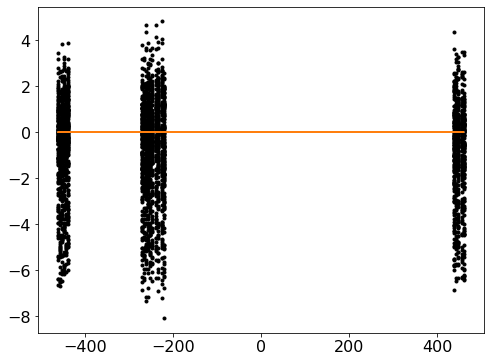

In [33]:
plt.plot(x, y, '.k')
with model:
    plt.plot(x, pmx.eval_in_model(light_curves, map_soln))
    
    mod = extras["light_curves"][:, 0]
    plt.plot(x, mod, label="planet {0}")
#plt.xlim(-275,-265)
#plt.savefig('transits_fit_1273.png',dpi=400,bbox_inches='tight')

In [ ]:
#here is a section where they remove outliers and re-build the model, I skipped it

In [35]:
import platform

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/juan/anaconda3/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:503: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/home/juan/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


KeyboardInterrupt: 

In [ ]:
import arviz as az

az.summary(trace, var_names=['omega', 'ecc', 'r_pl', 'b', 't0', 
                             'period', 'r_star', 'm_star', 'u_star', 'mean'])

#trace
#log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean